# 投票集成

## 1. 投票集成

投票集成(voting ensemble)

一种机器学习集成算法，同时使用多个模型，结合这些模型的预测，根据多数投票原则做出最后预测。投票集成能同时解决分类和回归问题。

如何结合多个模型的预测？

* 回归问题：计算所有预测值的平均值
* 分类问题：根据所有模型预测结果的多数投票做出最终决定

在分类问题中，多数投票有两种方式：

1. 硬投票(hard voting): 根据预测类别进行多数投票
2. 软投票(soft voting): 根据预测概率之和进行多数投票

什么时候使用投票集成？

1. 有两个以上表现良好的预测模型
2. 集成模型的性能比单个模型更好，例如交叉验证评分更高，否则应使用单个模型

投票集成的缺点？

集成的所有单个模型的权重相同，这意味着好的模型和糟糕的模型对最终预测的贡献一致，当单个模型表现差异较大，集成模型的性能可能表现一般。

参考：[如何用Python实现投票集成](https://machinelearningmastery.com/voting-ensembles-with-python/)

In [8]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

## 2. 投票分类器

准备数据，使用iris数据集。

In [9]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


sklearn提供接口VotingClassifier实现投票集成。

先创建多个模型实例，存放在列表中，传递给VotingClassifier。

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

lr: 0.973(0.033)
knn: 0.967(0.045)
nb: 0.953(0.043)
svm: 0.973(0.033)
voting: 0.973(0.033)


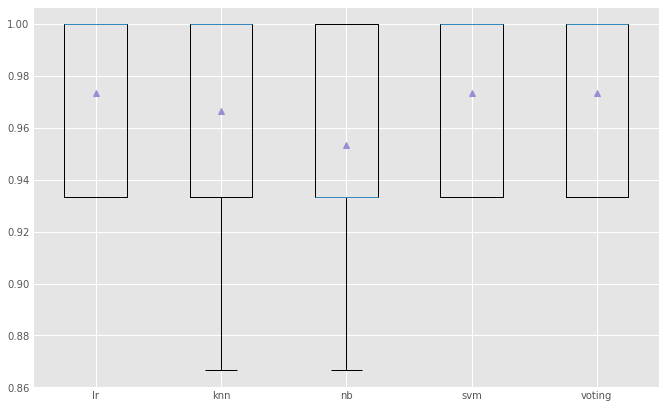

In [11]:
# 创建要集成的单个模型，存放在列表中，[('name1','model1'), ('name2', 'model2')]
models = []
models.append(("lr", LogisticRegression()))
models.append(("knn", KNeighborsClassifier()))
models.append(("nb", GaussianNB()))
models.append(("svm", SVC(probability=True)))  # 设置probability=True让SVM支持predict_prob()

# 创建投票分类器，投票方式可选择'hard' or 'soft'
voting = VotingClassifier(estimators=models, voting="hard")

# 使用交叉验证测试所有模型的性能，预期投票集成比单个模型更好
models2 = copy.deepcopy(models)
models2.append(("voting", voting))

names, scores = [], []
for name, model in models2:
    cvscores = cross_val_score(
        model, X=iris.data, y=iris.target, scoring="accuracy", cv=10, n_jobs=-1)
    names.append(name)
    scores.append(cvscores)
    print(f"{name}: {np.mean(cvscores):.3f}({np.std(cvscores):.3f})")
    
# 用箱线图对比所有模型的交叉验证评分
fig, ax = plt.subplots(figsize=(10, 7))
bp = ax.boxplot(scores, labels=names, showmeans=True)

结果显示，投票集成的性能不逊于任意单个模型，但并没有比所有模型更好，在这种情况下使用单个模型更合适。

VotingClassifier的使用方法跟其它分类器没有区别，配置好实例后，调用fit()拟合数据，调用predict()预测。

In [12]:
# 划分训练集和检验集
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, random_state=123)

# 拟合数据
voting.fit(X_train, y_train)

# 预测
y_pred = voting.predict(X_test)

# 检验预测评分
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.77      1.00      0.87        10
           2       1.00      0.82      0.90        17

    accuracy                           0.93        45
   macro avg       0.92      0.94      0.92        45
weighted avg       0.95      0.93      0.93        45



## 3. 投票回归器

准备数据，使用boston数据集。

In [13]:
from sklearn.datasets import load_boston

boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df["target"] = boston.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


sklearn提供接口VotingRegressor实现投票集成。

先创建多个模型实例，存放在列表中，传递给VotingRegressor。

与上面分类案例不同，这里仅使用决策树回归模型，通过调整"max_depth"来创建不同的模型实例，作为投票集成的输入。

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

cart(1): -6.338(2.416)
cart(2): -4.618(1.358)
cart(3): -4.332(1.179)
cart(4): -3.859(1.193)
cart(5): -3.753(1.286)
voting: -4.111(1.457)


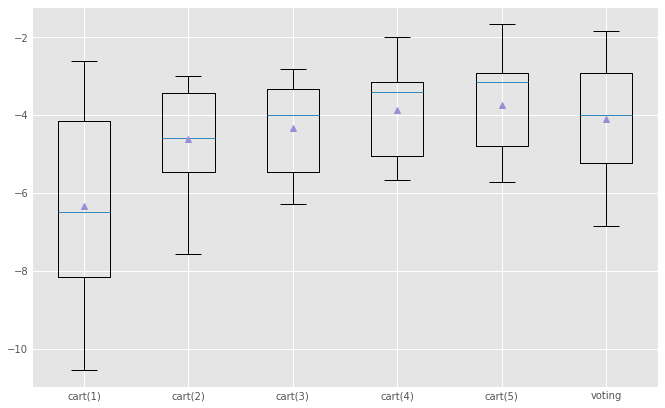

In [15]:
# 创建要集成的单个模型，存放在列表中，[('name1','model1'), ('name2', 'model2')]
models = []
models.append(("cart(1)", DecisionTreeRegressor(max_depth=1)))
models.append(("cart(2)", DecisionTreeRegressor(max_depth=2)))
models.append(("cart(3)", DecisionTreeRegressor(max_depth=3)))
models.append(("cart(4)", DecisionTreeRegressor(max_depth=4)))
models.append(("cart(5)", DecisionTreeRegressor(max_depth=5)))

# 创建投票回归器
voting = VotingRegressor(estimators=models)

# 使用交叉验证测试所有模型的性能，预期投票集成比单个模型更好
models2 = copy.deepcopy(models)
models2.append(("voting", voting))

names, scores = [], []
for name, model in models2:
    cvscores = cross_val_score(
        model, X=boston.data, y=boston.target, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
    names.append(name)
    scores.append(cvscores)
    print(f"{name}: {np.mean(cvscores):.3f}({np.std(cvscores):.3f})")
    
# 用箱线图对比所有模型的交叉验证评分
fig, ax = plt.subplots(figsize=(10, 7))
bp = ax.boxplot(scores, labels=names, showmeans=True)

随着最大深度上升，单个决策回归树的预测精度也随着上升。由于单个模型表现分化严重，所以投票集成的性能比部分模型差。

这充分说明一点，只有当单个模型都表现优秀且性能接近时，才应该使用投票集成。

VotingRegressor与单个回归模型的使用方法相同，先调用fit拟合训练集，再调用predict预测。

MAE: 3.332
R2: 0.718


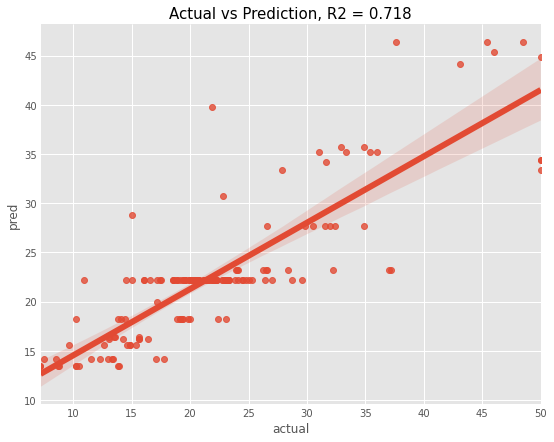

In [25]:
# 划分训练集和检验集
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.3, random_state=123)

# 拟合数据
voting.fit(X_train, y_train)

# 预测
y_pred = voting.predict(X_test)

# 检验预测评分
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(f"MAE: {mae:.3f}")
print(f"R2: {r2:.3f}")

# 散点图：预测值 vs 实际值
import seaborn as sns

pred_df = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})

lmplot = sns.lmplot("actual", "pred", data=pred_df, height=6, aspect=1.3)
title = lmplot.ax.set_title(f"Actual vs Prediction, R2 = {r2:.3f}", fontsize=15)